In [20]:
nasdaq100_tickers = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMD", "AMAT", "AMGN",
    "AMZN", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR",
    "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO",
    "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG",
    "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDLZ", "MELI", "META", "MNST", "PEP", "PLTR", "PYPL", "QCOM", "REGN", "ROP",
    "ROST", "SBUX", "SHOP", "SNPS", "TEAM", "TMUS", "TSLA", "TTD", "TTWO", "TXN",
    "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"
]

# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import run_full_analysis

In [ ]:
# Advanced Metrics Functions

def calculate_max_drawdown(equity_curve):
    cummax = equity_curve.cummax()
    drawdown = (equity_curve - cummax) / cummax * 100
    return drawdown.min()


def calculate_cagr(initial_value, final_value, num_years):
    if num_years == 0 or initial_value <= 0:
        return 0
    return (((final_value / initial_value) ** (1 / num_years)) - 1) * 100


def calculate_sharpe_ratio(returns, periods_per_year=252):
    if len(returns) == 0 or returns.std() == 0:
        return 0
    return (returns.mean() / returns.std()) * np.sqrt(periods_per_year)


def calculate_profit_factor(df):
    position_changes = df["Position"].diff()
    entries = df[position_changes == 1].index
    exits = df[position_changes == -1].index
    
    if len(entries) == 0 or len(exits) == 0:
        return 0
    
    # calculate trade-level returns
    trade_returns = []
    for i in range(min(len(entries), len(exits))):
        entry_idx = entries[i]
        exit_idx = exits[i]
        
        if exit_idx > entry_idx:
            entry_value = df.loc[entry_idx, "Strategy_Portfolio_Value"]
            exit_value = df.loc[exit_idx, "Strategy_Portfolio_Value"]
            trade_return = exit_value - entry_value
            trade_returns.append(trade_return)
    
    if len(trade_returns) == 0:
        return 0
    
    profits = sum([r for r in trade_returns if r > 0])
    losses = abs(sum([r for r in trade_returns if r < 0]))
    
    if losses == 0:
        return profits if profits > 0 else 0
    
    return profits / losses


def calculate_advanced_metrics(df):
    metrics = {}
    
    # final values
    initial_investment = df["Strategy_Portfolio_Value"].iloc[0] if len(df) > 0 else 10000
    metrics['strategy_final'] = df["Strategy_Portfolio_Value"].iloc[-1]
    metrics['simple_final'] = df["Simple_Portfolio_Value"].iloc[-1]
    
    # total returns
    metrics['strategy_return_pct'] = ((metrics['strategy_final'] - initial_investment) / initial_investment) * 100
    metrics['simple_return_pct'] = ((metrics['simple_final'] - initial_investment) / initial_investment) * 100
    
    # calculate number of years
    num_years = (df.index[-1] - df.index[0]).days / 365.25
    metrics['num_years'] = num_years
    
    # cagr
    metrics['strategy_cagr'] = calculate_cagr(initial_investment, metrics['strategy_final'], num_years)
    metrics['simple_cagr'] = calculate_cagr(initial_investment, metrics['simple_final'], num_years)
    
    # max drawdown
    metrics['strategy_max_drawdown'] = calculate_max_drawdown(df["Strategy_Portfolio_Value"])
    metrics['simple_max_drawdown'] = calculate_max_drawdown(df["Simple_Portfolio_Value"])
    
    # sharpe ratio
    metrics['strategy_sharpe'] = calculate_sharpe_ratio(df["Strategy_Return"])
    metrics['simple_sharpe'] = calculate_sharpe_ratio(df["Daily_Return"])
    
    # win rate (days with positive strategy returns when in position)
    in_position = df[df["Position"] == 1]
    if len(in_position) > 0:
        winning_days = len(in_position[in_position["Strategy_Return"] > 0])
        metrics['win_rate'] = (winning_days / len(in_position)) * 100
    else:
        metrics['win_rate'] = 0
    
    # profit factor
    metrics['profit_factor'] = calculate_profit_factor(df)
    
    # number of trades (complete entry-exit pairs)
    position_changes = df["Position"].diff()
    entries = (position_changes == 1).sum()
    exits = (position_changes == -1).sum()
    metrics['num_trades'] = min(entries, exits)
    
    return metrics

## Cohen Parameters Analysis

Analyzing Cohen's recommended parameters:
- **Degree**: 4
- **Window**: 60 days
- **Bandwidth**: 2.0

This section calculates all advanced metrics across the NASDAQ-100 universe.

In [43]:

cohen_degree = 4
cohen_window = 60
cohen_bandwidth = 2.0

data_dir = "nasdaq100_data"
all_results = []

for ticker in nasdaq100_tickers:
    try:
        # stock data
        csv_path = os.path.join(data_dir, f"{ticker}.csv")
        if not os.path.exists(csv_path):
            print(f"Skipping {ticker}: file not found")
            continue
        
        df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
        
        # run analysis
        df_analyzed = run_full_analysis(df, degree=cohen_degree, window=cohen_window, k=cohen_bandwidth)
        metrics = calculate_advanced_metrics(df_analyzed)
        metrics['ticker'] = ticker
        
        all_results.append(metrics)
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# convert to df
cohen_results = pd.DataFrame(all_results)

print(f"\nPreview of results:")
print(cohen_results[['ticker', 'strategy_cagr', 'strategy_sharpe', 'strategy_max_drawdown', 'profit_factor', 'win_rate']].head())


Preview of results:
  ticker  strategy_cagr  strategy_sharpe  strategy_max_drawdown  \
0   AAPL      17.105591         0.867409             -31.500173   
1   ABNB     -14.557531        -0.307199             -66.042193   
2   ADBE      15.888873         0.769769             -38.669766   
3    ADI      12.923515         0.700610             -27.478574   
4    ADP       7.902727         0.559800             -32.981568   

   profit_factor   win_rate  
0       2.586596  53.907496  
1       0.513645  48.326360  
2       1.346462  53.438865  
3       2.219460  53.648069  
4       1.470807  54.470284  


In [44]:

print(f"\nStrategy CAGR:")
print(f"Mean:   {cohen_results['strategy_cagr'].mean():>8.2f}%")
print(f"Median: {cohen_results['strategy_cagr'].median():>8.2f}%")
print(f"Std:    {cohen_results['strategy_cagr'].std():>8.2f}%")
print(f"Min:    {cohen_results['strategy_cagr'].min():>8.2f}%")
print(f"Max:    {cohen_results['strategy_cagr'].max():>8.2f}%")

print(f"\nBuy-and-Hold CAGR:")
print(f"Mean:   {cohen_results['simple_cagr'].mean():>8.2f}%")
print(f"Median: {cohen_results['simple_cagr'].median():>8.2f}%")
print(f"Std:    {cohen_results['simple_cagr'].std():>8.2f}%")
print(f"Min:    {cohen_results['simple_cagr'].min():>8.2f}%")
print(f"Max:    {cohen_results['simple_cagr'].max():>8.2f}%")

print(f"\nStrategy vs Buy-and-Hold:")
outperform_count = (cohen_results['strategy_cagr'] > cohen_results['simple_cagr']).sum()
print(f"Stocks where strategy outperforms: {outperform_count}/{len(cohen_results)} ({100*outperform_count/len(cohen_results):.1f}%)")
print(f"Average CAGR difference: {(cohen_results['strategy_cagr'] - cohen_results['simple_cagr']).mean():.2f}%")

print(f"\nTop 5 Strategy CAGR performers:")
top_5_cagr = cohen_results.nlargest(5, 'strategy_cagr')[['ticker', 'strategy_cagr', 'simple_cagr']]
print(top_5_cagr.to_string(index=False))


Strategy CAGR:
Mean:      12.06%
Median:    10.98%
Std:       11.73%
Min:      -14.56%
Max:       97.64%

Buy-and-Hold CAGR:
Mean:      21.58%
Median:    19.51%
Std:       17.44%
Min:       -6.33%
Max:      119.55%

Strategy vs Buy-and-Hold:
Stocks where strategy outperforms: 11/86 (12.8%)
Average CAGR difference: -9.53%

Top 5 Strategy CAGR performers:
ticker  strategy_cagr  simple_cagr
   ARM      97.637543   119.554751
  META      27.970871    24.639404
  AVGO      27.903844    38.990327
   TTD      27.769763    57.876798
   CEG      27.017766    95.164121


In [45]:
# max drawdown analysis

print(f"\nStrategy Max Drawdown:")
print(f"Mean:   {cohen_results['strategy_max_drawdown'].mean():>8.2f}%")
print(f"Median: {cohen_results['strategy_max_drawdown'].median():>8.2f}%")
print(f"Worst:  {cohen_results['strategy_max_drawdown'].min():>8.2f}%")
print(f"Best:   {cohen_results['strategy_max_drawdown'].max():>8.2f}%")

print(f"\nBuy-and-Hold Max Drawdown:")
print(f"Mean:   {cohen_results['simple_max_drawdown'].mean():>8.2f}%")
print(f"Median: {cohen_results['simple_max_drawdown'].median():>8.2f}%")
print(f"Worst:  {cohen_results['simple_max_drawdown'].min():>8.2f}%")
print(f"Best:   {cohen_results['simple_max_drawdown'].max():>8.2f}%")

print(f"\nRisk Reduction:")
lower_dd_count = (cohen_results['strategy_max_drawdown'] > cohen_results['simple_max_drawdown']).sum()
print(f"Stocks with lower drawdown (strategy): {lower_dd_count}/{len(cohen_results)} ({100*lower_dd_count/len(cohen_results):.1f}%)")
print(f"Average drawdown reduction: {(cohen_results['strategy_max_drawdown'] - cohen_results['simple_max_drawdown']).mean():.2f}%")

print(f"\nTop 5 stocks with best (lowest) strategy drawdown:")
top_5_dd = cohen_results.nlargest(5, 'strategy_max_drawdown')[['ticker', 'strategy_max_drawdown', 'simple_max_drawdown']]
print(top_5_dd.to_string(index=False))


Strategy Max Drawdown:
Mean:     -43.88%
Median:   -38.96%
Worst:    -84.90%
Best:     -14.53%

Buy-and-Hold Max Drawdown:
Mean:     -53.08%
Median:   -50.55%
Worst:    -91.90%
Best:     -24.86%

Risk Reduction:
Stocks with lower drawdown (strategy): 73/86 (84.9%)
Average drawdown reduction: 9.21%

Top 5 stocks with best (lowest) strategy drawdown:
ticker  strategy_max_drawdown  simple_max_drawdown
   PEP             -14.525447           -28.817072
   AEP             -16.099626           -32.905208
   LIN             -18.736008           -32.585056
  MDLZ             -20.073578           -29.741949
  COST             -20.325341           -31.402443


In [46]:
# sharpe ratio analysis

print(f"\nStrategy Sharpe Ratio:")
print(f"Mean:   {cohen_results['strategy_sharpe'].mean():>8.2f}")
print(f"Median: {cohen_results['strategy_sharpe'].median():>8.2f}")
print(f"Std:    {cohen_results['strategy_sharpe'].std():>8.2f}")
print(f"Min:    {cohen_results['strategy_sharpe'].min():>8.2f}")
print(f"Max:    {cohen_results['strategy_sharpe'].max():>8.2f}")

print(f"\nBuy-and-Hold Sharpe Ratio:")
print(f"Mean:   {cohen_results['simple_sharpe'].mean():>8.2f}")
print(f"Median: {cohen_results['simple_sharpe'].median():>8.2f}")
print(f"Std:    {cohen_results['simple_sharpe'].std():>8.2f}")
print(f"Min:    {cohen_results['simple_sharpe'].min():>8.2f}")
print(f"Max:    {cohen_results['simple_sharpe'].max():>8.2f}")

print(f"\nRisk-Adjusted Performance:")
better_sharpe_count = (cohen_results['strategy_sharpe'] > cohen_results['simple_sharpe']).sum()
print(f"Stocks with better Sharpe (strategy): {better_sharpe_count}/{len(cohen_results)} ({100*better_sharpe_count/len(cohen_results):.1f}%)")
print(f"Average Sharpe difference: {(cohen_results['strategy_sharpe'] - cohen_results['simple_sharpe']).mean():.2f}")

print(f"\nTop 5 Strategy Sharpe performers:")
top_5_sharpe = cohen_results.nlargest(5, 'strategy_sharpe')[['ticker', 'strategy_sharpe', 'simple_sharpe']]
print(top_5_sharpe.to_string(index=False))


Strategy Sharpe Ratio:
Mean:       0.58
Median:     0.60
Std:        0.28
Min:       -0.31
Max:        1.78

Buy-and-Hold Sharpe Ratio:
Mean:       0.71
Median:     0.73
Std:        0.26
Min:       -0.01
Max:        1.76

Risk-Adjusted Performance:
Stocks with better Sharpe (strategy): 26/86 (30.2%)
Average Sharpe difference: -0.13

Top 5 Strategy Sharpe performers:
ticker  strategy_sharpe  simple_sharpe
   ARM         1.778687       1.317612
  COST         1.097959       1.113737
  AVGO         1.084123       1.094800
   CEG         1.002548       1.757787
  META         0.993412       0.751740



Win Rate Statistics:
Mean:      52.62%
Median:    52.62%
Std:        1.77%
Min:       48.33%
Max:       60.66%

Win Rate Distribution:
Stocks with win rate >= 50%: 81/86 (94.2%)
Stocks with win rate >= 60%: 1/86 (1.2%)

Top 5 Win Rate performers:
ticker  win_rate  num_trades
   ARM 60.655738           8
  CTAS 56.731757         112
   CEG 56.293706          18
  AVGO 55.185384         112
   AEP 55.106499         114


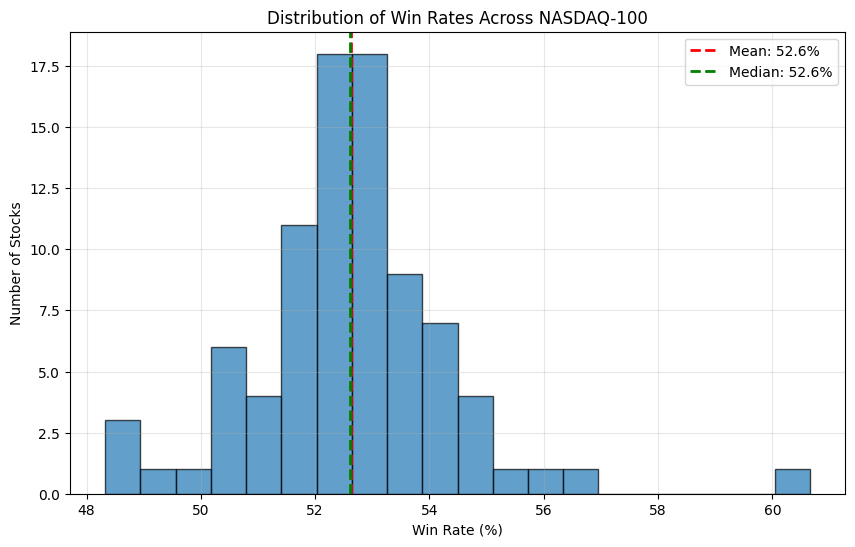

In [47]:
# win rate analysis

print(f"\nWin Rate Statistics:")
print(f"Mean:   {cohen_results['win_rate'].mean():>8.2f}%")
print(f"Median: {cohen_results['win_rate'].median():>8.2f}%")
print(f"Std:    {cohen_results['win_rate'].std():>8.2f}%")
print(f"Min:    {cohen_results['win_rate'].min():>8.2f}%")
print(f"Max:    {cohen_results['win_rate'].max():>8.2f}%")

print(f"\nWin Rate Distribution:")
high_win_rate = (cohen_results['win_rate'] >= 50).sum()
print(f"Stocks with win rate >= 50%: {high_win_rate}/{len(cohen_results)} ({100*high_win_rate/len(cohen_results):.1f}%)")
very_high_win_rate = (cohen_results['win_rate'] >= 60).sum()
print(f"Stocks with win rate >= 60%: {very_high_win_rate}/{len(cohen_results)} ({100*very_high_win_rate/len(cohen_results):.1f}%)")

print(f"\nTop 5 Win Rate performers:")
top_5_wr = cohen_results.nlargest(5, 'win_rate')[['ticker', 'win_rate', 'num_trades']]
print(top_5_wr.to_string(index=False))

# histogram
plt.figure(figsize=(10, 6))
plt.hist(cohen_results['win_rate'], bins=20, edgecolor='black', alpha=0.7)
plt.axvline(cohen_results['win_rate'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cohen_results["win_rate"].mean():.1f}%')
plt.axvline(cohen_results['win_rate'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {cohen_results["win_rate"].median():.1f}%')
plt.xlabel('Win Rate (%)')
plt.ylabel('Number of Stocks')
plt.title('Distribution of Win Rates Across NASDAQ-100')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
# profit factor 

print(f"\nProfit Factor Statistics:")
print(f"Mean:   {cohen_results['profit_factor'].mean():>8.2f}")
print(f"Median: {cohen_results['profit_factor'].median():>8.2f}")
print(f"Std:    {cohen_results['profit_factor'].std():>8.2f}")
print(f"Min:    {cohen_results['profit_factor'].min():>8.2f}")
print(f"Max:    {cohen_results['profit_factor'].max():>8.2f}")

print(f"\nProfit Factor Breakdown:")
profitable_count = (cohen_results['profit_factor'] > 1).sum()
print(f"Stocks with PF > 1 (profitable): {profitable_count}/{len(cohen_results)} ({100*profitable_count/len(cohen_results):.1f}%)")
very_profitable_count = (cohen_results['profit_factor'] > 1.5).sum()
print(f"Stocks with PF > 1.5 (very profitable): {very_profitable_count}/{len(cohen_results)} ({100*very_profitable_count/len(cohen_results):.1f}%)")

print(f"\nRelationship to CAGR:")
print(f"Correlation (PF vs CAGR): {cohen_results['profit_factor'].corr(cohen_results['strategy_cagr']):.3f}")

print(f"\nTop 5 Profit Factor performers:")
top_5_pf = cohen_results.nlargest(5, 'profit_factor')[['ticker', 'profit_factor', 'strategy_cagr', 'win_rate']]
print(top_5_pf.to_string(index=False))


Profit Factor Statistics:
Mean:       1.69
Median:     1.51
Std:        0.74
Min:        0.51
Max:        6.43

Profit Factor Breakdown:
Stocks with PF > 1 (profitable): 81/86 (94.2%)
Stocks with PF > 1.5 (very profitable): 44/86 (51.2%)

Relationship to CAGR:
Correlation (PF vs CAGR): 0.818

Top 5 Profit Factor performers:
ticker  profit_factor  strategy_cagr  win_rate
   ARM       6.428084      97.637543 60.655738
  COST       3.610416      14.986786 53.317394
  AMZN       2.937952      15.836240 52.713178
  FAST       2.817429      14.983810 54.540511
   AEP       2.790100      12.172765 55.106499


In [49]:
# Summary

print(f"\nPortfolio Overview:")
print(f"  Total stocks analyzed: {len(cohen_results)}")
print(f"  Average time period: {cohen_results['num_years'].mean():.2f} years")
print(f"  Average trades per stock: {cohen_results['num_trades'].mean():.1f}")

print(f"\n{'Metric':<30} {'Strategy':<15} {'Buy & Hold':<15} {'Difference':<15}")
print("-"*75)
print(f"{'CAGR (mean)':<30} {cohen_results['strategy_cagr'].mean():>12.2f}%  {cohen_results['simple_cagr'].mean():>12.2f}%  {(cohen_results['strategy_cagr'] - cohen_results['simple_cagr']).mean():>12.2f}%")
print(f"{'Sharpe Ratio (mean)':<30} {cohen_results['strategy_sharpe'].mean():>14.2f}  {cohen_results['simple_sharpe'].mean():>14.2f}  {(cohen_results['strategy_sharpe'] - cohen_results['simple_sharpe']).mean():>14.2f}")
print(f"{'Max Drawdown (mean)':<30} {cohen_results['strategy_max_drawdown'].mean():>12.2f}%  {cohen_results['simple_max_drawdown'].mean():>12.2f}%  {(cohen_results['strategy_max_drawdown'] - cohen_results['simple_max_drawdown']).mean():>12.2f}%")

print(f"\nStrategy-Specific Metrics:")
print(f"  Average Win Rate: {cohen_results['win_rate'].mean():.2f}%")
print(f"  Average Profit Factor: {cohen_results['profit_factor'].mean():.2f}")
print(f"  Stocks profitable (PF > 1): {(cohen_results['profit_factor'] > 1).sum()}/{len(cohen_results)} ({100*(cohen_results['profit_factor'] > 1).sum()/len(cohen_results):.1f}%)")

print(f"\nKey Findings:")
outperform_cagr = (cohen_results['strategy_cagr'] > cohen_results['simple_cagr']).sum()
outperform_sharpe = (cohen_results['strategy_sharpe'] > cohen_results['simple_sharpe']).sum()
better_dd = (cohen_results['strategy_max_drawdown'] > cohen_results['simple_max_drawdown']).sum()

# save results
output_path = "Cohen_Data/cohen_advanced_metrics.csv"
os.makedirs("Cohen_Data", exist_ok=True)
cohen_results.to_csv(output_path, index=False)


Portfolio Overview:
  Total stocks analyzed: 86
  Average time period: 12.93 years
  Average trades per stock: 93.8

Metric                         Strategy        Buy & Hold      Difference     
---------------------------------------------------------------------------
CAGR (mean)                           12.06%         21.58%         -9.53%
Sharpe Ratio (mean)                      0.58            0.71           -0.13
Max Drawdown (mean)                  -43.88%        -53.08%          9.21%

Strategy-Specific Metrics:
  Average Win Rate: 52.62%
  Average Profit Factor: 1.69
  Stocks profitable (PF > 1): 81/86 (94.2%)

Key Findings:


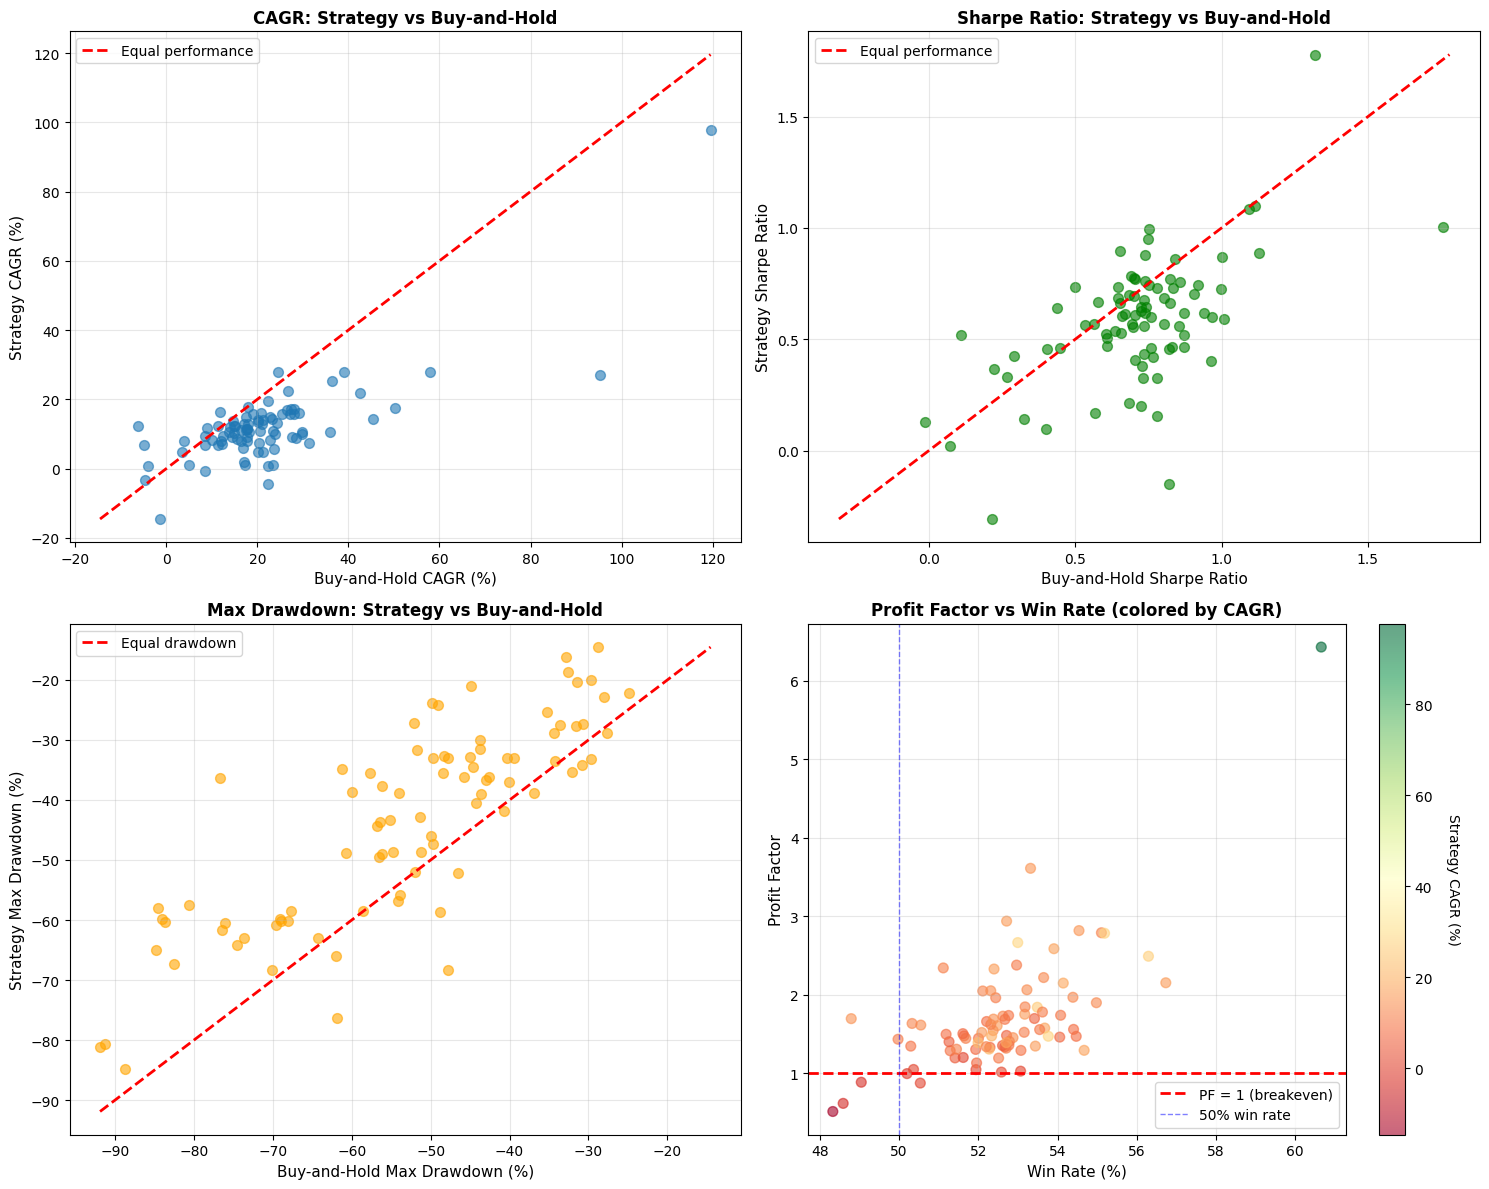

In [50]:
# Visualization of Key Metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# cagr comparison
ax1 = axes[0, 0]
ax1.scatter(cohen_results['simple_cagr'], cohen_results['strategy_cagr'], alpha=0.6, s=50)
min_val = min(cohen_results['simple_cagr'].min(), cohen_results['strategy_cagr'].min())
max_val = max(cohen_results['simple_cagr'].max(), cohen_results['strategy_cagr'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Equal performance')
ax1.set_xlabel('Buy-and-Hold CAGR (%)', fontsize=11)
ax1.set_ylabel('Strategy CAGR (%)', fontsize=11)
ax1.set_title('CAGR: Strategy vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# sharpe ratio comparison
ax2 = axes[0, 1]
ax2.scatter(cohen_results['simple_sharpe'], cohen_results['strategy_sharpe'], alpha=0.6, s=50, color='green')
min_val = min(cohen_results['simple_sharpe'].min(), cohen_results['strategy_sharpe'].min())
max_val = max(cohen_results['simple_sharpe'].max(), cohen_results['strategy_sharpe'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Equal performance')
ax2.set_xlabel('Buy-and-Hold Sharpe Ratio', fontsize=11)
ax2.set_ylabel('Strategy Sharpe Ratio', fontsize=11)
ax2.set_title('Sharpe Ratio: Strategy vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# max drawdown comparison
ax3 = axes[1, 0]
ax3.scatter(cohen_results['simple_max_drawdown'], cohen_results['strategy_max_drawdown'], alpha=0.6, s=50, color='orange')
min_val = min(cohen_results['simple_max_drawdown'].min(), cohen_results['strategy_max_drawdown'].min())
max_val = max(cohen_results['simple_max_drawdown'].max(), cohen_results['strategy_max_drawdown'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Equal drawdown')
ax3.set_xlabel('Buy-and-Hold Max Drawdown (%)', fontsize=11)
ax3.set_ylabel('Strategy Max Drawdown (%)', fontsize=11)
ax3.set_title('Max Drawdown: Strategy vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# profit factor vs win rate
ax4 = axes[1, 1]
scatter = ax4.scatter(cohen_results['win_rate'], cohen_results['profit_factor'], 
                      c=cohen_results['strategy_cagr'], cmap='RdYlGn', alpha=0.6, s=50)
ax4.axhline(y=1, color='r', linestyle='--', linewidth=2, label='PF = 1 (breakeven)')
ax4.axvline(x=50, color='b', linestyle='--', linewidth=1, alpha=0.5, label='50% win rate')
ax4.set_xlabel('Win Rate (%)', fontsize=11)
ax4.set_ylabel('Profit Factor', fontsize=11)
ax4.set_title('Profit Factor vs Win Rate (colored by CAGR)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Strategy CAGR (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()


Now, I am curious about Cohen's statement regarding that:
- A degree 4 polynomial is best
- A 60 day window is best
- A band width of 2 is best

I am curious to find out if this is correct, by testing every possibility. 

In [51]:
from utils import run_full_analysis, calculate_metrics
import warnings
warnings.filterwarnings('ignore')

# ranges 
degrees = range(1, 10)
windows = range(20, 121, 10)
bandwidths = np.arange(0.5, 4.1, 0.1)

data_dir = "nasdaq100_data"

In [52]:
# although you could argue that it is slower to keep all results cached in "results", it is necessary for visualization later
results = []

output_dir = "Analysis_Data"

total_iterations = len(list(degrees)) * len(list(windows)) * len(bandwidths)
# need to keep track of this because it takes about 24 hours to get all the data (shoulve used C++)
current_iteration = 0
skipped_count = 0
calculated_count = 0

for degree in degrees:
    for window in windows:
        for bandwidth in bandwidths:
            current_iteration += 1
            
            # create a directory for these parameters
            param_dir = os.path.join(
                output_dir, 
                f"degree_{degree}",
                f"window_{window}",
                f"bandwidth_{bandwidth:.1f}"
            )
            os.makedirs(param_dir, exist_ok=True)
            
            # check if this combination has already been calculated
            summary_path = os.path.join(param_dir, "summary.csv")
            all_metrics_path = os.path.join(param_dir, "all_metrics.csv")
            
            if os.path.exists(summary_path) and os.path.exists(all_metrics_path):
                # load existing results
                try:
                    summary_df = pd.read_csv(summary_path)
                    results.append({
                        'degree': summary_df.iloc[0]['degree'],
                        'window': summary_df.iloc[0]['window'],
                        'bandwidth': summary_df.iloc[0]['bandwidth'],
                        'avg_return': summary_df.iloc[0]['avg_return'],
                        'num_stocks': summary_df.iloc[0]['num_stocks']
                    })
                    skipped_count += 1
                    
                    # i want to see progress
                    if current_iteration % 100 == 0:
                        print(f"Progress: {current_iteration}/{total_iterations} ({100*current_iteration/total_iterations:.1f}%)")
                    
                    continue

                except Exception as e:
                    print(f"Warning: Could not load cached result for {param_dir}, recalculating...")
            
            # so we have to calculate now
            ticker_returns = []
            all_ticker_metrics = []
            
            for ticker in nasdaq100_tickers:
                try:
                    # load  data
                    csv_path = os.path.join(data_dir, f"{ticker}.csv")
                    if not os.path.exists(csv_path):
                        continue
                    
                    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                    
                    # analysis
                    df_analyzed = run_full_analysis(df, degree=degree, window=window, k=bandwidth)
                    metrics = calculate_metrics(df_analyzed)
                    metrics['ticker'] = ticker
                    all_ticker_metrics.append(metrics)
                    ticker_returns.append(metrics['strategy_return_pct'])
                    
                except Exception as e:
                    # skip any tickers with errors. (data should already be cleaned although, but I want to be safe)
                    print(e)
                    continue
            
            # calculare the returns from all the tickers
            if ticker_returns:
                avg_return = np.mean(ticker_returns)
                
                results.append({
                    'degree': degree,
                    'window': window,
                    'bandwidth': bandwidth,
                    'avg_return': avg_return,
                    'num_stocks': len(ticker_returns)
                })
                
                # put everything into one csv
                all_metrics_df = pd.DataFrame(all_ticker_metrics)
                all_metrics_df.to_csv(all_metrics_path, index=False)
                
                # Save summary
                pd.DataFrame([{
                    'degree': degree,
                    'window': window,
                    'bandwidth': bandwidth,
                    'avg_return': avg_return,
                    'num_stocks': len(ticker_returns),
                    'min_return': min(ticker_returns),
                    'max_return': max(ticker_returns),
                    'median_return': np.median(ticker_returns),
                    'std_return': np.std(ticker_returns)
                }]).to_csv(summary_path, index=False)
                
                calculated_count += 1
            
            # update progress every 10 because it is slower
            if current_iteration % 10 == 0 and calculated_count > 0:
                print(f"Progress: {current_iteration}/{total_iterations} ({100*current_iteration/total_iterations:.1f}%) - Calculated: {calculated_count}, Cached: {skipped_count}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("FINISHED")
print(f"Total combinations: {len(results_df)}")
print(f"Newly calculated: {calculated_count}")
print(f"Loaded from cache: {skipped_count}")
print(f"Best 10 parameter combinations by average return:")
print(results_df.nlargest(10, 'avg_return')[['degree', 'window', 'bandwidth', 'avg_return']])

Progress: 100/3564 (2.8%)
Progress: 200/3564 (5.6%)
Progress: 300/3564 (8.4%)
Progress: 400/3564 (11.2%)
Progress: 500/3564 (14.0%)
Progress: 600/3564 (16.8%)
Progress: 700/3564 (19.6%)
Progress: 800/3564 (22.4%)
Progress: 900/3564 (25.3%)
Progress: 1000/3564 (28.1%)
Progress: 1100/3564 (30.9%)
Progress: 1200/3564 (33.7%)
Progress: 1300/3564 (36.5%)
Progress: 1400/3564 (39.3%)
Progress: 1500/3564 (42.1%)
Progress: 1600/3564 (44.9%)
Progress: 1700/3564 (47.7%)
Progress: 1800/3564 (50.5%)
Progress: 1900/3564 (53.3%)
Progress: 2000/3564 (56.1%)
Progress: 2100/3564 (58.9%)
Progress: 2200/3564 (61.7%)
Progress: 2300/3564 (64.5%)
Progress: 2400/3564 (67.3%)
Progress: 2500/3564 (70.1%)
Progress: 2600/3564 (73.0%)
Progress: 2700/3564 (75.8%)
Progress: 2800/3564 (78.6%)
Progress: 2900/3564 (81.4%)
Progress: 3000/3564 (84.2%)
Progress: 3100/3564 (87.0%)
Progress: 3200/3564 (89.8%)
Progress: 3300/3564 (92.6%)
Progress: 3400/3564 (95.4%)
Progress: 3500/3564 (98.2%)
FINISHED
Total combinations: 356

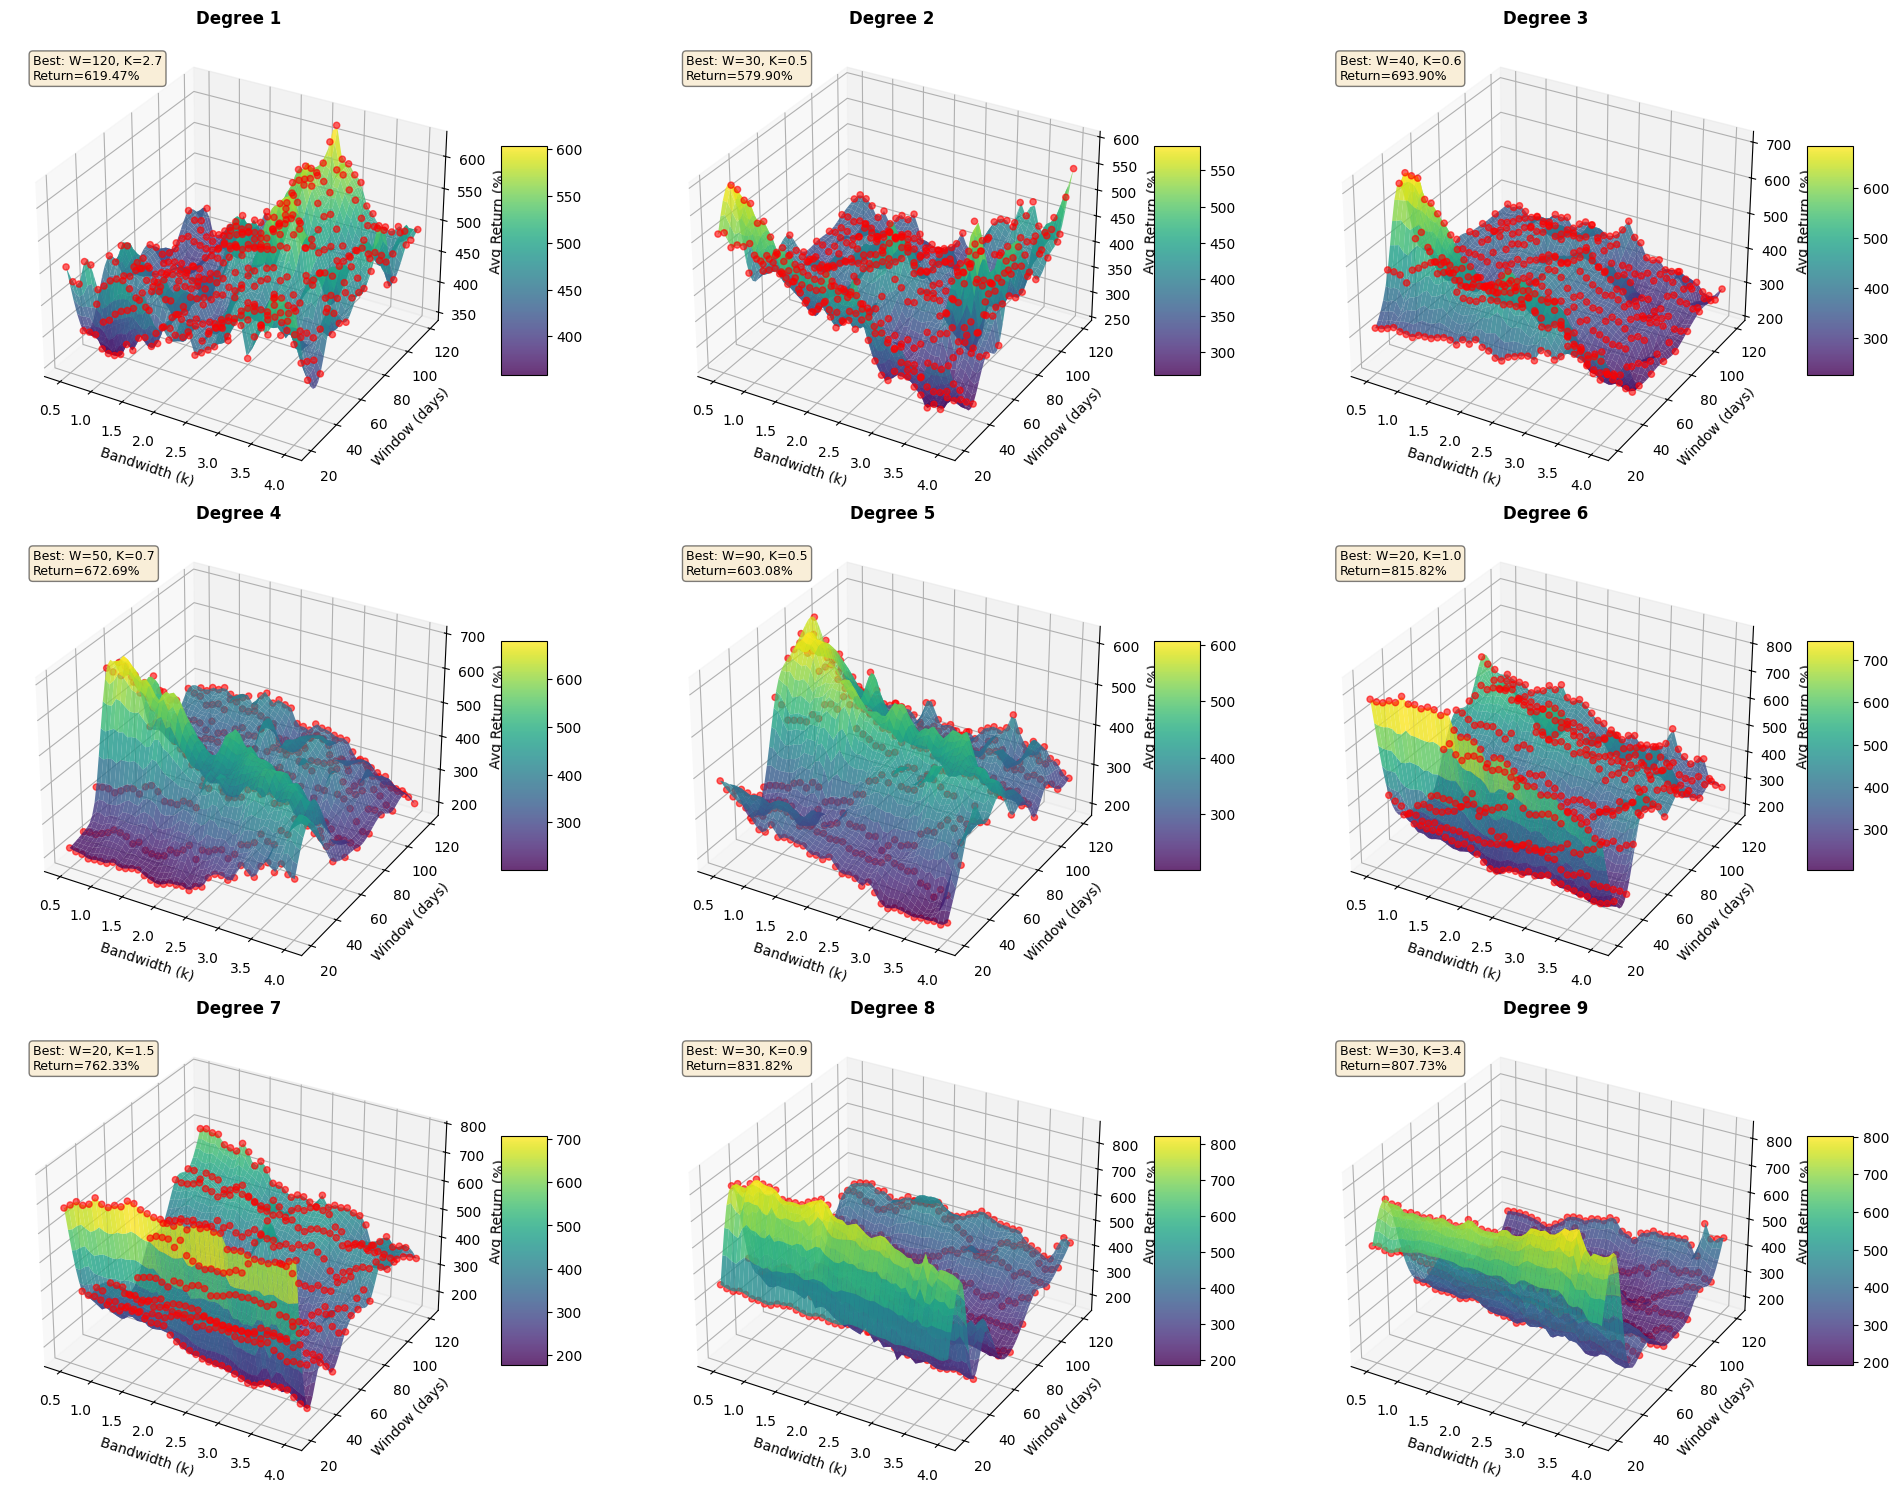

In [53]:
# now lets visualize the perofrmance 
from scipy.interpolate import griddata

n_degrees = len(list(degrees))
n_cols = 3
n_rows = (n_degrees + n_cols - 1) // n_cols

fig = plt.figure(figsize=(20, 5 * n_rows))

for idx, degree in enumerate(degrees, 1):
    degree_data = results_df[results_df['degree'] == degree]
    # make sure that we have data for this degree
    if len(degree_data) == 0:
        continue

    x = degree_data['bandwidth'].values
    y = degree_data['window'].values
    z = degree_data['avg_return'].values
    
    # bounds for the grid
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    
    # z values
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # 3D subplot
    ax = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
    
    # surface plot
    # the parameters here can be adjusted for better visualization
    surf = ax.plot_surface(xi, yi, zi, cmap='viridis', alpha=0.8, edgecolor='none')
    
    # actual data points
    ax.scatter(x, y, z, c='red', marker='o', s=20, alpha=0.6)
    
    ax.set_xlabel('Bandwidth (k)', fontsize=10)
    ax.set_ylabel('Window (days)', fontsize=10)
    ax.set_zlabel('Avg Return (%)', fontsize=10)
    ax.set_title(f'Degree {degree}', fontsize=12, fontweight='bold')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # best parameters for this degree
    best_idx = degree_data['avg_return'].idxmax()
    best_params = degree_data.loc[best_idx]
    
    # Annotate best point
    ax.text2D(0.05, 0.95, 
              f"Best: W={best_params['window']:.0f}, K={best_params['bandwidth']:.1f}\nReturn={best_params['avg_return']:.2f}%",
              transform=ax.transAxes, fontsize=9, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
output_path = os.path.join(output_dir, 'parameter_optimization_3d.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()



Overall Best Parameters:
Degree: 8
Window: 30 days
Bandwidth: 0.9
Average Return: 831.82%
Tested on 86 stocks

Best Parameters by Degree:
Degree 1: Window=120, Bandwidth=2.7, Return=619.47%
Degree 2: Window=30, Bandwidth=0.5, Return=579.90%
Degree 3: Window=40, Bandwidth=0.6, Return=693.90%
Degree 4: Window=50, Bandwidth=0.7, Return=672.69%
Degree 5: Window=90, Bandwidth=0.5, Return=603.08%
Degree 6: Window=20, Bandwidth=1.0, Return=815.82%
Degree 7: Window=20, Bandwidth=1.5, Return=762.33%
Degree 8: Window=30, Bandwidth=0.9, Return=831.82%
Degree 9: Window=30, Bandwidth=3.4, Return=807.73%


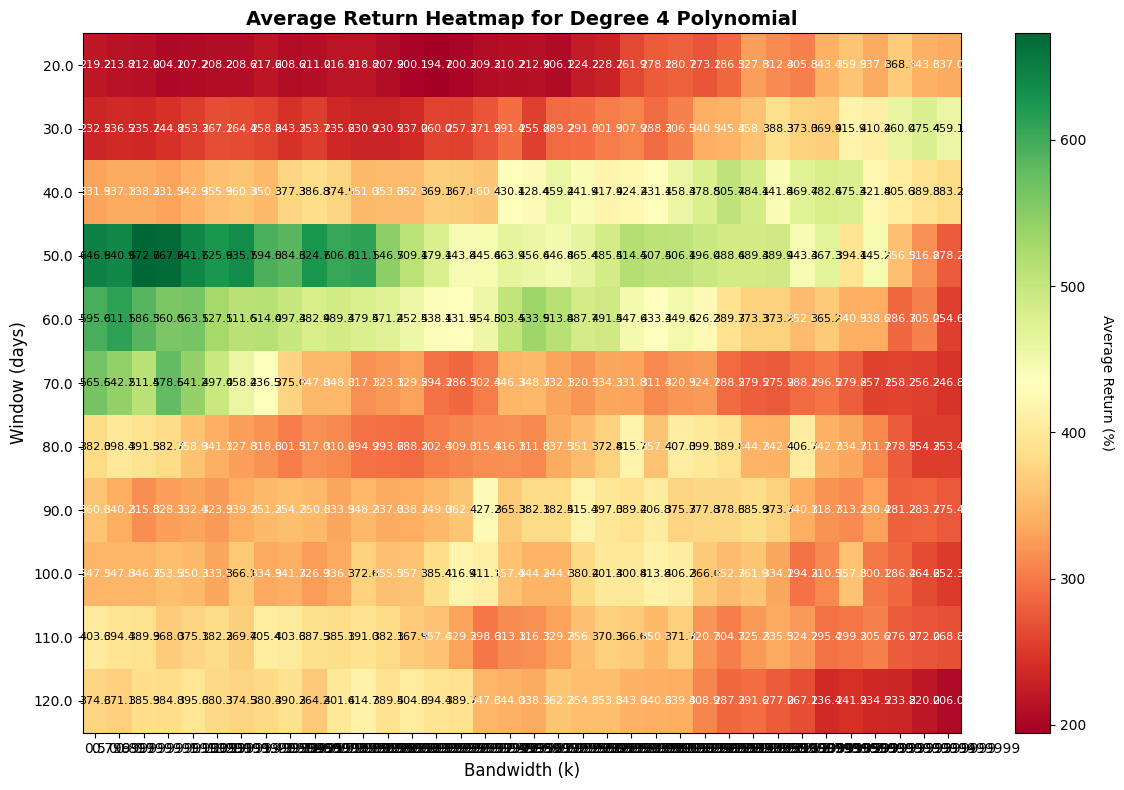

In [59]:

# best overall parameters
best_overall = results_df.loc[results_df['avg_return'].idxmax()]
print(f"\nOverall Best Parameters:")
print(f"Degree: {best_overall['degree']:.0f}")
print(f"Window: {best_overall['window']:.0f} days")
print(f"Bandwidth: {best_overall['bandwidth']:.1f}")
print(f"Average Return: {best_overall['avg_return']:.2f}%")
print(f"Tested on {best_overall['num_stocks']:.0f} stocks")

# Cohen's recommended parameters
cohen_params = results_df[
    (results_df['degree'] == 4) & 
    (results_df['window'] == 60) & 
    (results_df['bandwidth'] == 2.0)
]

# best parameters by degree
print(f"\nBest Parameters by Degree:")
for degree in degrees:
    degree_data = results_df[results_df['degree'] == degree]
    if len(degree_data) > 0:
        best = degree_data.loc[degree_data['avg_return'].idxmax()]
        print(f"Degree {degree}: Window={best['window']:.0f}, Bandwidth={best['bandwidth']:.1f}, Return={best['avg_return']:.2f}%")

# Create a heatmap for degree=4 (Cohen's degree)

degree_4_data = results_df[results_df['degree'] == 4].copy()

# Pivot the data for heatmap
heatmap_data = degree_4_data.pivot(index='window', columns='bandwidth', values='avg_return')

plt.figure(figsize=(12, 8))
im = plt.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto')

# Set ticks and labels
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.xlabel('Bandwidth (k)', fontsize=12)
plt.ylabel('Window (days)', fontsize=12)
plt.title('Average Return Heatmap for Degree 4 Polynomial', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Average Return (%)', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if not np.isnan(value):
            color = 'white' if value < heatmap_data.values[~np.isnan(heatmap_data.values)].mean() else 'black'
            plt.text(j, i, f'{value:.1f}', ha='center', va='center', color=color, fontsize=8)

# Highlight Cohen's parameters (window=60, bandwidth=2)
if 60 in heatmap_data.index and 2.0 in heatmap_data.columns:
    cohen_i = list(heatmap_data.index).index(60)
    cohen_j = list(heatmap_data.columns).index(2.0)
    plt.plot(cohen_j, cohen_i, 'b*', markersize=20, markeredgewidth=2, markeredgecolor='blue', 
             markerfacecolor='none', label="Cohen's params")
    plt.legend()

plt.tight_layout()
heatmap_path = os.path.join(output_dir, 'degree_4_heatmap.png')
plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# lets save the results to csv just in case
csv_path = os.path.join(output_dir, 'parameter_optimization_results.csv')
results_df.to_csv(csv_path, index=False)

print(f"\nTotal parameter combinations tested: {len(results_df)}")
print(f"\nAverage Return Statistics:")
print(f"Mean: {results_df['avg_return'].mean():.2f}%")
print(f"Median: {results_df['avg_return'].median():.2f}%")
print(f"Std Dev: {results_df['avg_return'].std():.2f}%")
print(f"Min: {results_df['avg_return'].min():.2f}%")
print(f"Max: {results_df['avg_return'].max():.2f}%")


Total parameter combinations tested: 3564

Average Return Statistics:
Mean: 382.69%
Median: 366.25%
Std Dev: 113.59%
Min: 179.52%
Max: 831.82%


In [56]:
# comprehensize index file
index_data = []

for degree in degrees:
    for window in windows:
        for bandwidth in bandwidths:
            param_dir = os.path.join(
                output_dir, 
                f"degree_{degree}",
                f"window_{window}",
                f"bandwidth_{bandwidth:.1f}"
            )
            
            summary_path = os.path.join(param_dir, "summary.csv")
            
            if os.path.exists(summary_path):
                summary_df = pd.read_csv(summary_path)
                summary_dict = summary_df.iloc[0].to_dict()
                summary_dict['directory'] = param_dir
                index_data.append(summary_dict)

index_df = pd.DataFrame(index_data)
index_path = os.path.join(output_dir, 'master_index.csv')
index_df.to_csv(index_path, index=False)
